In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

## PCA

In [24]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_data/'
f = h5py.File(path_to_filtered_data+'pool_ex8_PCs.h5','r')
lengths_data = np.array(f['MetaData/lengths_data'], dtype=int)
pca_fish = ma.array(f['pca_fish'])[:,:,:20]
data_means = ma.array(f['data_means'])
eigvecs = ma.array(f['eigvecs'])
cov = ma.array(f['cov'])
var_exp = np.array(f['var_exp'])
max_shuffs = np.array(f['max_shuffs'])
f.close()

In [3]:
print(np.sum(lengths_data[0:25]))

61582


In [4]:
print(data_means.shape)

(10, 18, 1400)


In [5]:
var_exp = np.reshape(var_exp, (var_exp.shape[0]*var_exp.shape[1], 1400))

In [6]:
m, cil, ciu = stats.bootstrap(var_exp, n_times = 1000)

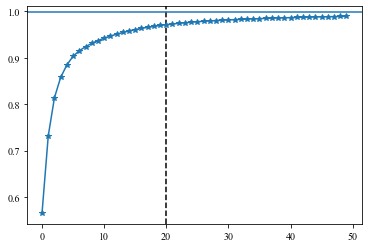

In [7]:
# plt.plot(m[:50])
plt.errorbar(np.arange(0,50), m[:50], [m[:50] - cil[:50],ciu[:50] - m[:50]], fmt='-*')
plt.axvline(20, ls = '--', c='k')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl1/var_exp.pdf')
plt.axhline(1-max_shuffs[0,0])
# plt.fill_between
# plt.xlim(0,300)

In [8]:
eigvecs = 180*(eigvecs/np.pi)

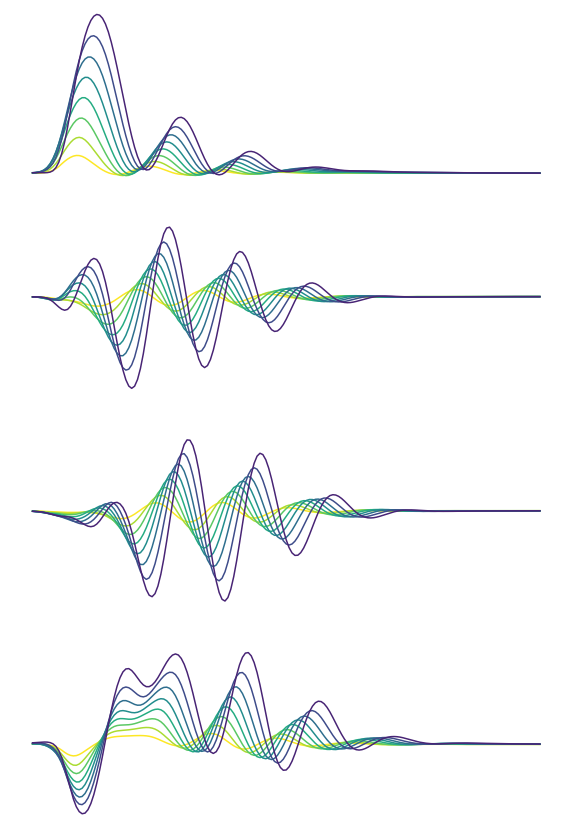

In [9]:
fig,ax = plt.subplots(4,1,figsize=(10,15))

colors_ = plt.cm.viridis_r(np.linspace(0,0.9,8))
# for i in range(8):
for i in range(8):
    ax[0].plot(eigvecs[:,0].reshape(175,8)[:,i],color = colors_[i])
    ax[1].plot(eigvecs[:,1].reshape(175,8)[:,i],color = colors_[i])
    ax[2].plot(eigvecs[:,2].reshape(175,8)[:,i],color = colors_[i])
    ax[3].plot(eigvecs[:,3].reshape(175,8)[:,i],color = colors_[i])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
# plt.colorbar()
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl1/4pcs.pdf')
plt.show()

## Entropy

In [10]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_data/'
f1 = h5py.File(path_to_filtered_data+'Entropy_seeds_delays_clusters.h5','r')
total_entropy= np.array(f1['entropies'],dtype=float)
f1.close()

In [11]:
print(total_entropy.shape)

(100, 9, 22)


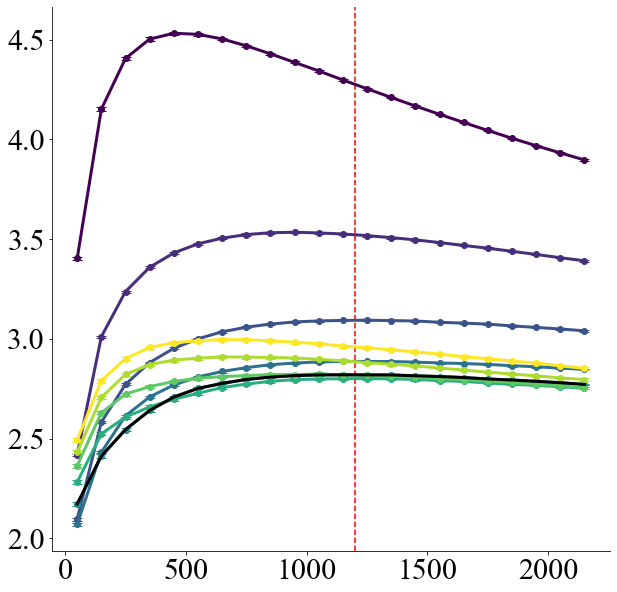

In [12]:
K_range = np.arange(1,10)
n_clusters = np.arange(50,2250,100)

colors_ = plt.cm.viridis(np.linspace(0,1,K_range.shape[0]))
# colors_ = plt.cm.Reds(np.linspace(0,1,n_clusters.shape[0]))
# colors_ = plt.cm.viridis(np.linspace(0,1,10))

fig,ax = plt.subplots(1,1,figsize=(10,10))
for k in range(K_range.shape[0]):
    mean,cil,ciu = stats.bootstrap(total_entropy[:,k,:].squeeze(),n_times=1000)
    ax.errorbar(n_clusters,mean,[mean-cil,ciu-mean],marker='o', color=colors_[k], lw = 3, elinewidth=3, capsize=5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
ax.axvline(1200,ls='--',c='r')
mean_seed,cil, ciu = stats.bootstrap(total_entropy[:,4,:], n_times=1000)
ax.plot(n_clusters,mean_seed, color='k',label= r'Delay $K = 5$', lw=3, alpha=1.0, zorder=10)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig1/Entropy_nflip_K_N1200.pdf')
plt.show()

### Example bout sequences

In [25]:
# Fig 1 K=3, N=1000

record_list = []
for i,l in enumerate(lengths_data):
    pca_fish[i,l-1,:] = ma.masked
    record_list.append(pca_fish[i,:l,:])

In [26]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [27]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [28]:
K=3

N_cluster=1000

min_count = 200

bouts = 7500

data = record_list
    
data_bootstrap = np.asarray(copy.deepcopy(data),dtype='object')
    
sampled_data = []
for cond in condition_labels:
    cond_recs = np.where(conditions[:,1] == cond)[0]
    samples_ = ma.zeros((bouts+4, data_bootstrap[0].shape[1]))
    data_cond = ma.concatenate(data_bootstrap[cond_recs], axis=0)
    start_pos = np.random.randint(0, len(data_cond)-bouts)
    samples_[2:-2] = data_cond[start_pos:start_pos+bouts]
    samples_[samples_ == 0] = ma.masked
    sampled_data.append(samples_)

#for kf,f0 in enumerate(np.arange(0,data_bootstrap.shape[0],div)):
pc_ = ma.concatenate(sampled_data,axis=0)
print('Starting delay {}, clusters {}:'.format(K, N_cluster), pc_.shape, flush=True)
if ma.count(pc_,axis=0)[0]>min_count:
    traj_matrix_3 = embed.trajectory_matrix(pc_,K=K-1)
    labels_3 = cl.kmeans_knn_partition(traj_matrix_3,N_cluster,batchsize=10000)

Starting delay 3, clusters 1000: (105056, 20)


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


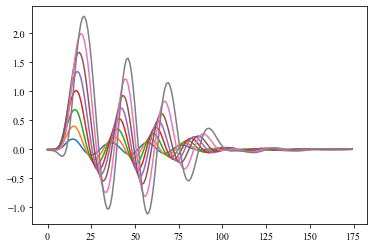

In [52]:
plt.plot(traj_matrix_3[105].reshape(3,20)[0].dot(eigvecs[:,:20].T).reshape(175,8))
plt.show()

In [53]:
K=3
label=503
all_traces_3 = []
ntraces_3 = (labels_3==label).sum()
print(ntraces_3)
for ks in range(ntraces_3):
    traces_K=ma.zeros(200*K)
    for k in range(K):
        traces_K[int(200*k):int(200*k)+175] = traj_matrix_3[labels_3==label][ks].reshape(K,20)[k].dot(eigvecs[:,:20].T).reshape(175,8)[:,-1]
    traces_K[traces_K==0] = ma.masked
    all_traces_3.append(traces_K)

156


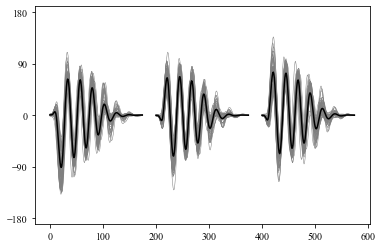

In [57]:
for ks in np.random.randint(0,ntraces_3,50):
    plt.plot((all_traces_3[ks])*(180/np.pi),c='gray',alpha=1,lw=.5)
plt.plot((ma.mean(all_traces_3,axis=0))*(180/np.pi),c='k')
plt.ylim(-190,190)
plt.yticks(np.arange(-180,181,90))
# plt.savefig('example_K3_N1000.pdf')

plt.show()

In [58]:
# Fig S1 K=5, N=1200

K=5

N_cluster=1200

min_count = 200

bouts = 7500

data = record_list
    
data_bootstrap = np.asarray(copy.deepcopy(data),dtype='object')
    
sampled_data = []
for cond in condition_labels:
    cond_recs = np.where(conditions[:,1] == cond)[0]
    samples_ = ma.zeros((bouts+4, data_bootstrap[0].shape[1]))
    data_cond = ma.concatenate(data_bootstrap[cond_recs], axis=0)
    start_pos = np.random.randint(0, len(data_cond)-bouts)
    samples_[2:-2] = data_cond[start_pos:start_pos+bouts]
    samples_[samples_ == 0] = ma.masked
    sampled_data.append(samples_)

#for kf,f0 in enumerate(np.arange(0,data_bootstrap.shape[0],div)):
pc_ = ma.concatenate(sampled_data,axis=0)
print('Starting delay {}, clusters {}:'.format(K, N_cluster), pc_.shape, flush=True)
if ma.count(pc_,axis=0)[0]>min_count:
    traj_matrix_5 = embed.trajectory_matrix(pc_,K=K-1)
    labels_5 = cl.kmeans_knn_partition(traj_matrix_5,N_cluster,batchsize=10000)

Starting delay 5, clusters 1200: (105056, 20)


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [64]:
K=5
label=72
all_traces_5 = []
ntraces_5 = (labels_5==label).sum()
print(ntraces_5)
for ks in range(ntraces_5):
    traces_K=ma.zeros(200*K)
    for k in range(K):
        traces_K[int(200*k):int(200*k)+175] = traj_matrix_5[labels_5==label][ks].reshape(K,20)[k].dot(eigvecs[:,:20].T).reshape(175,8)[:,-1]
    traces_K[traces_K==0] = ma.masked
    all_traces_5.append(traces_K)

82


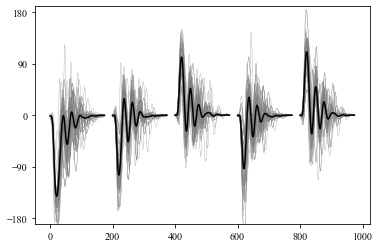

In [65]:
for ks in np.random.randint(0,ntraces_5,50):
    plt.plot((all_traces_5[ks])*(180/np.pi),c='gray',alpha=1,lw=.25)
plt.plot((ma.mean(all_traces_5,axis=0))*(180/np.pi),c='k')
plt.ylim(-190,190)
plt.yticks(np.arange(-180,181,90))
# plt.savefig('example_K5_N1200.pdf')

plt.show()

In [66]:
## Fig S1 D Number of visits

## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

In [67]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked
labels_fish = labels_fish_allrec

lengths_rem = lengths_all

In [68]:
unique_labels,counts =np.unique(labels_fish.compressed(),return_counts=True)

In [69]:
mean,cil,ciu = stats.bootstrap(counts,n_times=100)

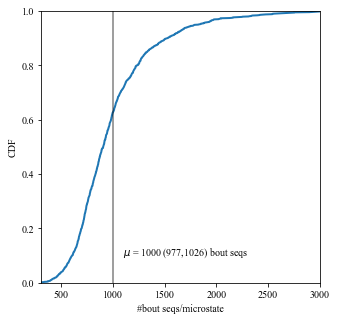

In [70]:
x,y = stats.cumulative_dist(counts,(0,4000))
plt.figure(figsize=(5,5))
plt.plot(x,y,lw=2)
plt.axvline(counts.mean(),c='k',alpha=.5)
plt.xlim(300,3000)
plt.text(1100,.1,"$\mu$ = {} ({},{}) bout seqs".format(int(mean),int(cil),int(ciu)))
plt.ylim(0,1)
plt.ylabel('CDF')
plt.xlabel('#bout seqs/microstate')
# plt.savefig('label_counts.pdf')
plt.show()